In [ ]:
import ccxt
import pandas as pd
import configparser
from datetime import datetime, timezone

config = configparser.ConfigParser()
config.read("config.ini")
api_key = config.get("settings", "api_key")
secret_key = config.get("settings", "secret_key")


def fetch_binance_data(symbol, type, interval, start_time, end_time):

    exchange = ccxt.binance(
        {
            "apiKey": api_key,
            "secret": secret_key,
            "options": {
                "defaultType": type,
            },
        }
    )

    interval_ms = exchange.parse_timeframe(interval) * 1000

    start_time = (
        int(
            datetime.strptime(start_time, "%d.%m.%y %H:%M:%S")
            .replace(tzinfo=timezone.utc)
            .timestamp()
        )
        * 1000
    )
    end_time = (
        int(
            datetime.strptime(end_time, "%d.%m.%y %H:%M:%S")
            .replace(tzinfo=timezone.utc)
            .timestamp()
        )
        * 1000
    )

    entries_count = (end_time - start_time) // int(interval_ms)
    entries = list()

    while entries_count > 0:
        ohlcv = exchange.fetch_ohlcv(
            symbol, interval, since=start_time, limit=min(500, entries_count)
        )
        entries_count = entries_count - len(ohlcv)
        last = ohlcv[-1][0]
        entries.extend(ohlcv)
        start_time = last + 1
        print(f"{symbol}_{type}: entries left: {entries_count}")
        print("------------")

    df = pd.DataFrame(
        entries, columns=["timestamp", "open", "high", "low", "close", "volume"]
    )
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df.set_index("timestamp", inplace=True)
    df["close"] = pd.to_numeric(df["close"])
    df.to_csv(f"{symbol}_{type}_data.csv")


symbol_futures = "BTCUSDT"
interval = "1m"
start_date = "01.01.23 00:00:00"
end_date = "01.01.24 00:00:00"

fetch_binance_data(symbol_futures, "future", interval, start_date, end_date)
fetch_binance_data(symbol_futures, "spot", interval, start_date, end_date)

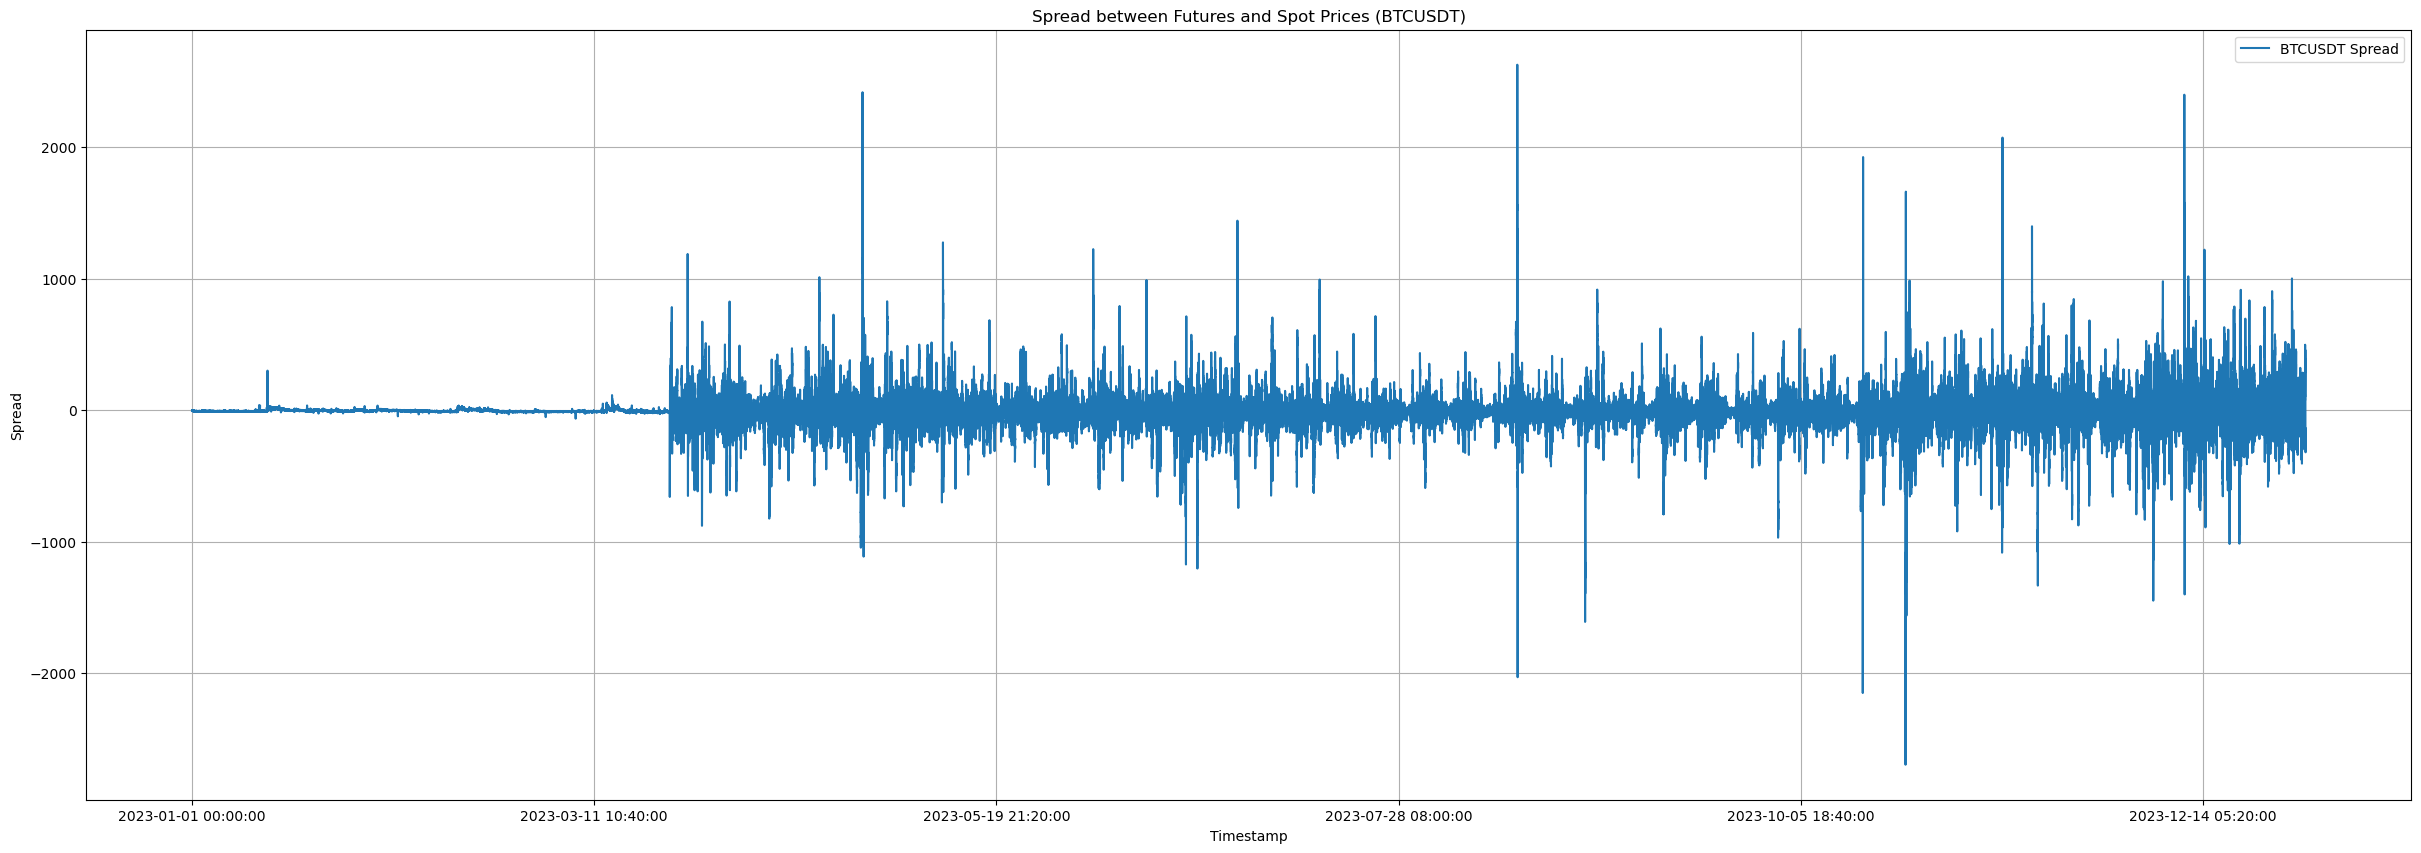

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.plotting.backend = "matplotlib"

data_futures = pd.read_csv("BTCUSDT_future_data.csv")
data_spot = pd.read_csv("BTCUSDT_spot_data.csv")

spread = pd.Series(
    (data_futures["close"] - data_spot["close"]).array,
    index=(data_futures["timestamp"]),
)
spread.plot(figsize=(30, 10))
plt.title("Spread between Futures and Spot Prices (BTCUSDT)")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.legend(["BTCUSDT Spread"])
plt.grid(True)

График иллюстрирует динамику спреда между ценами закрытия минутных свечей фьючерсного контракта BTCUSDT и соответствующего спотового рынка на платформе Binance за 2023 год.

В начале 2023 года наблюдаются устойчивые тренды с низкими колебаниями значений спреда в течение первых трех месяцев. Однако, для более точного понимания этого явления, необходимо провести дополнительный анализ, учитывая возможные влияния как макроэкономических факторов, так и качества предоставленных данных.

В четвертом квартале отмечается заметное увеличение вариативности значений спреда, что может свидетельствовать о возросшей неопределенности или изменениях в рыночной динамике.

Помимо этого, в течение года выделяются аномальные выбросы значений, которые требуют дополнительного анализа. Эти выбросы могут быть вызваны событиями, внутренними или внешними факторами, и их понимание имеет важное значение для корректной интерпретации данных.

В целом, полученные данные предоставляют возможность провести анализ колебаний спреда за год, выявить важные тренды и факторы, а также выполнить расчеты других ключевых показателей для более глубокого понимания рыночной ситуации.